In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

# Choose variants here:

In [2]:
arch = 'MnistResNet18'
num_images = 96
trained_model = True

## System setup:

In [3]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('MNIST', defs)

model, _ = inversefed.construct_model(arch, num_classes=100, num_channels=3)
model.to(**setup)
if trained_model:
    defs.epochs = 10
    file = f'{arch}_{defs.epochs}.pth'
    try:
        model.load_state_dict(torch.load(f'models/{file}'))
    except FileNotFoundError:
        inversefed.train(model, loss_fn, trainloader, validloader, defs, setup=setup)
        torch.save(model.state_dict(), f'models/{file}')
model.eval();

Currently evaluating -------------------------------:
Tuesday, 24. November 2020 05:25PM
CPUs: 12, GPUs: 2 on dmsx-MS-7B94.
GPU : GeForce RTX 2080 Ti
Files already downloaded and verified
Files already downloaded and verified
Model initialized with random key 127894434.


In [4]:
dm = torch.as_tensor(inversefed.consts.mnist_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.mnist_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

# Reconstruct

In [5]:
if num_images == 1:
    ground_truth_image = torch.as_tensor(np.array(Image.open("auto.jpg").resize((32, 32), Image.BICUBIC)) / 255, 
                                         **setup)
    ground_truth = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
    labels = torch.as_tensor((1,), device=setup['device'])
else:
    ground_truth, labels = [], []
    idx = 25 # choosen randomly ... just whatever you want
    while len(labels) < num_images:
        img, label = validloader.dataset[idx]
        idx += 1
        if label not in labels:
            labels.append(torch.as_tensor((label,), device=setup['device']))
            ground_truth.append(img.to(**setup))
    ground_truth = torch.stack(ground_truth)
    labels = torch.cat(labels)

In [6]:
def grid_plot(tensor, labels):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)

    fig, axes = plt.subplots(10, 10, figsize=(24, 24))
    for im, l, ax in zip(tensor, labels, axes.flatten()):
        ax.imshow(im.permute(1, 2, 0).cpu());
        ax.set_title(l)
        ax.axis('off')

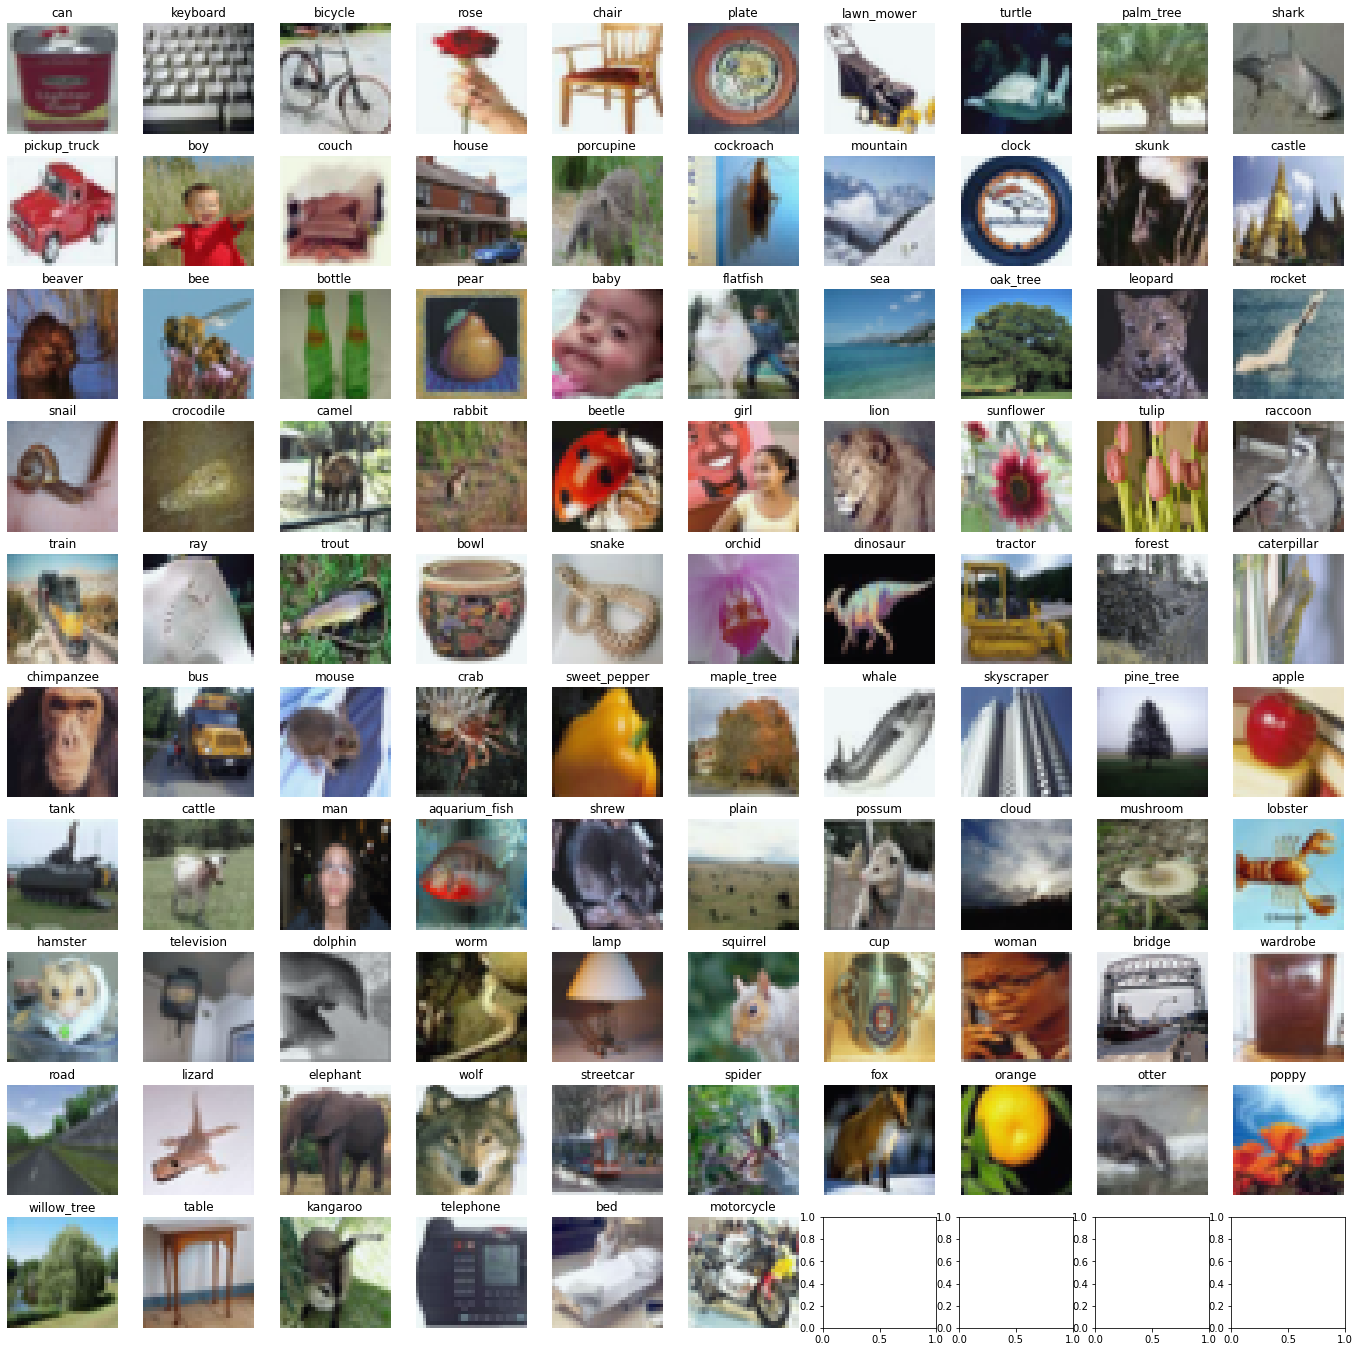

In [7]:
grid_plot(ground_truth, [validloader.dataset.classes[l] for l in labels]);
#print([validloader.dataset.classes[l] for l in labels]);

In [8]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

In [9]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=4,
              max_iterations=24000,
              total_variation=1e-2,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=num_images)
output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 32, 32))

It: 0. Rec. loss: 0.8144.
It: 500. Rec. loss: 0.1093.
It: 1000. Rec. loss: 0.0736.
It: 1500. Rec. loss: 0.1116.
It: 2000. Rec. loss: 0.0989.
It: 2500. Rec. loss: 0.0824.
It: 3000. Rec. loss: 0.0719.
It: 3500. Rec. loss: 0.0850.
It: 4000. Rec. loss: 0.0759.
It: 4500. Rec. loss: 0.0758.
It: 5000. Rec. loss: 0.0825.
It: 5500. Rec. loss: 0.0652.
It: 6000. Rec. loss: 0.0774.
It: 6500. Rec. loss: 0.0766.
It: 7000. Rec. loss: 0.0704.
It: 7500. Rec. loss: 0.0801.
It: 8000. Rec. loss: 0.0806.
It: 8500. Rec. loss: 0.0862.
It: 9000. Rec. loss: 0.0663.
It: 9500. Rec. loss: 0.0385.
It: 10000. Rec. loss: 0.0381.
It: 10500. Rec. loss: 0.0324.
It: 11000. Rec. loss: 0.0311.
It: 11500. Rec. loss: 0.0302.
It: 12000. Rec. loss: 0.0296.
It: 12500. Rec. loss: 0.0296.
It: 13000. Rec. loss: 0.0296.
It: 13500. Rec. loss: 0.0295.
It: 14000. Rec. loss: 0.0289.
It: 14500. Rec. loss: 0.0286.
It: 15000. Rec. loss: 0.0276.
It: 15500. Rec. loss: 0.0256.
It: 16000. Rec. loss: 0.0245.
It: 16500. Rec. loss: 0.0236.
It: 

Rec. loss: 0.0091 | MSE: 1.3644 | PSNR: -0.96 | FMSE: 1.8897e+00 |


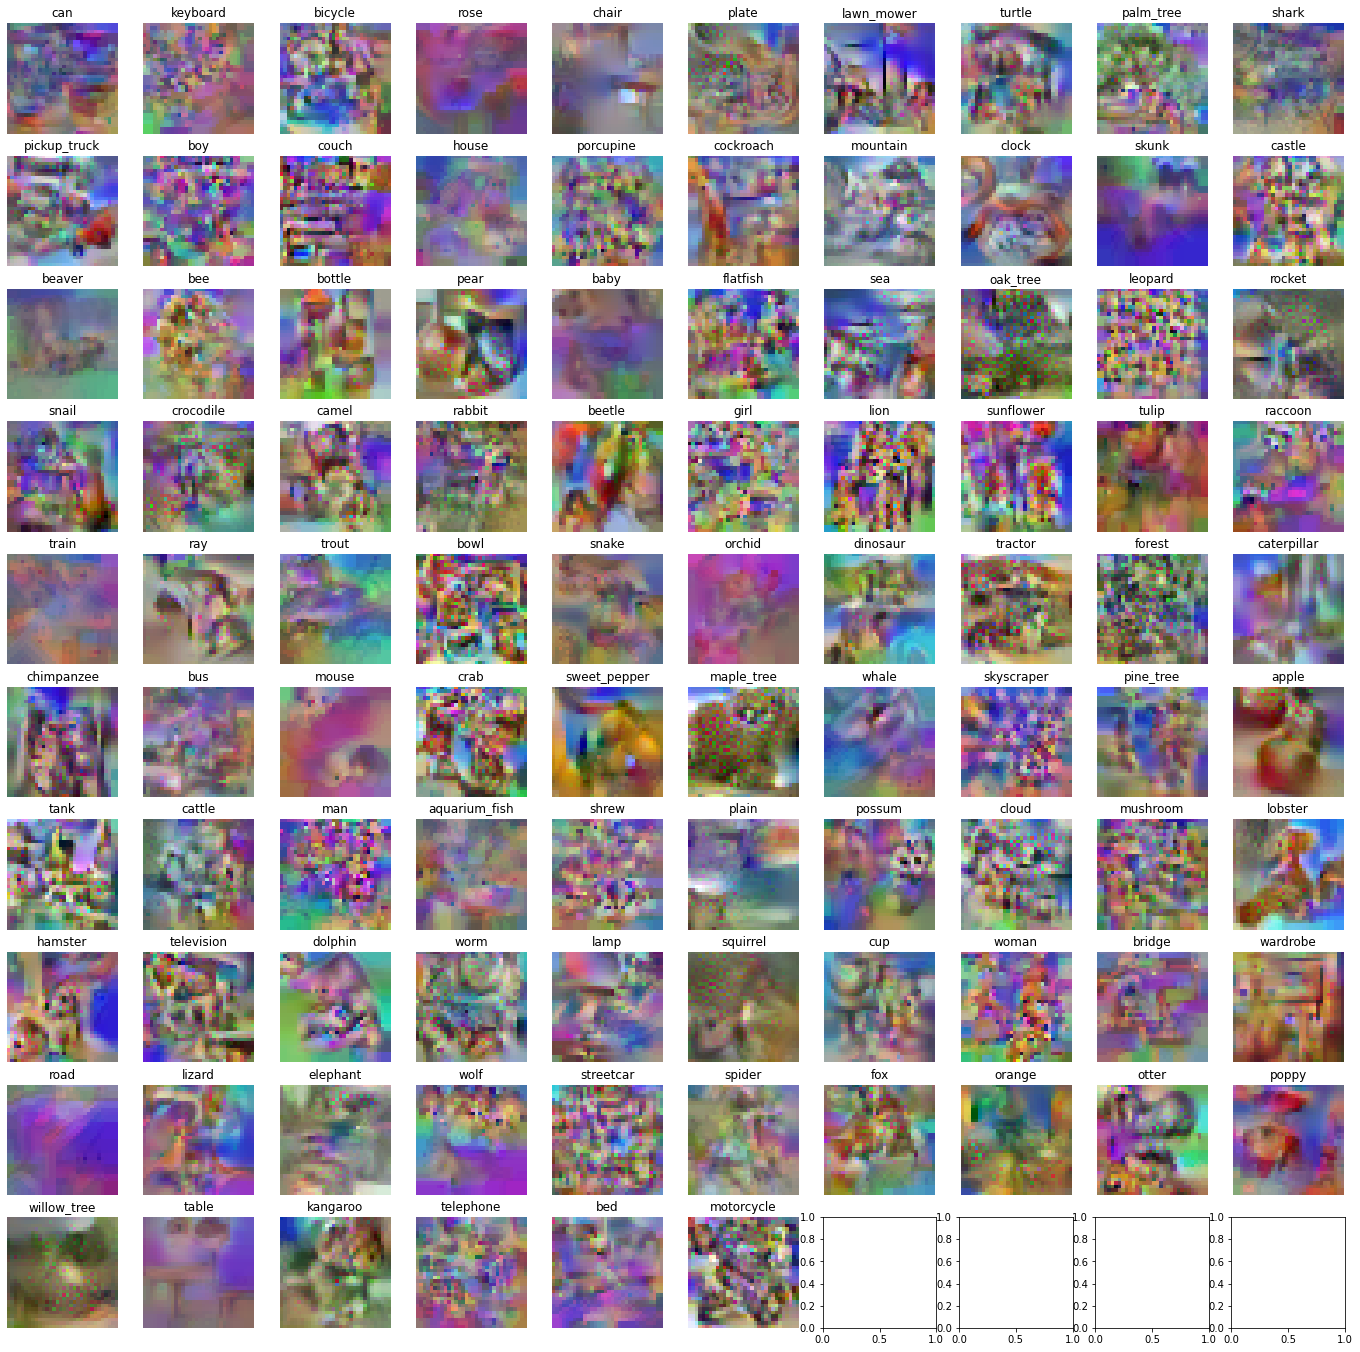

In [10]:
test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth)
grid_plot(output, [validloader.dataset.classes[l] for l in labels]);
print(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
      f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

Which classes break privacy depends on the initialization and state of the network.

### Noteworthy classes where privacy was broken in this run:

* trout
* bowl
* cockroach
* rocket
* sweet_pepper
* maple_tree
* willow_tree

In [11]:
gt = ground_truth.clone().detach().cpu()
gt_numpy = gt.numpy()
np.save(f'rec100{num_images}gtbatch', gt_numpy)

ot = output.clone().detach().cpu()
ot_numpy = ot.numpy()
np.save(f'rec100{num_images}otbatch', ot_numpy)

In [34]:
print(output.shape)
psnr = []
for i in range(num_images):
    psnr.append(inversefed.metrics.psnr(output[i:i+1], ground_truth[i:i+1]))

torch.Size([96, 3, 32, 32])


In [37]:
print(inversefed.metrics.psnr(output[0:1], output[0:1]))

inf


In [35]:
def grid_plot_psrn(tensor, labels, psnr):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    i = 0
    fig, axes = plt.subplots(10, 10, figsize=(24, 24))
    for im, l, ax in zip(tensor, labels, axes.flatten()):
        title = f'{psnr[i]:4.4f}'
        ax.imshow(im.permute(1, 2, 0).cpu());
        ax.set_title(title)
        ax.axis('off')
        i = i + 1

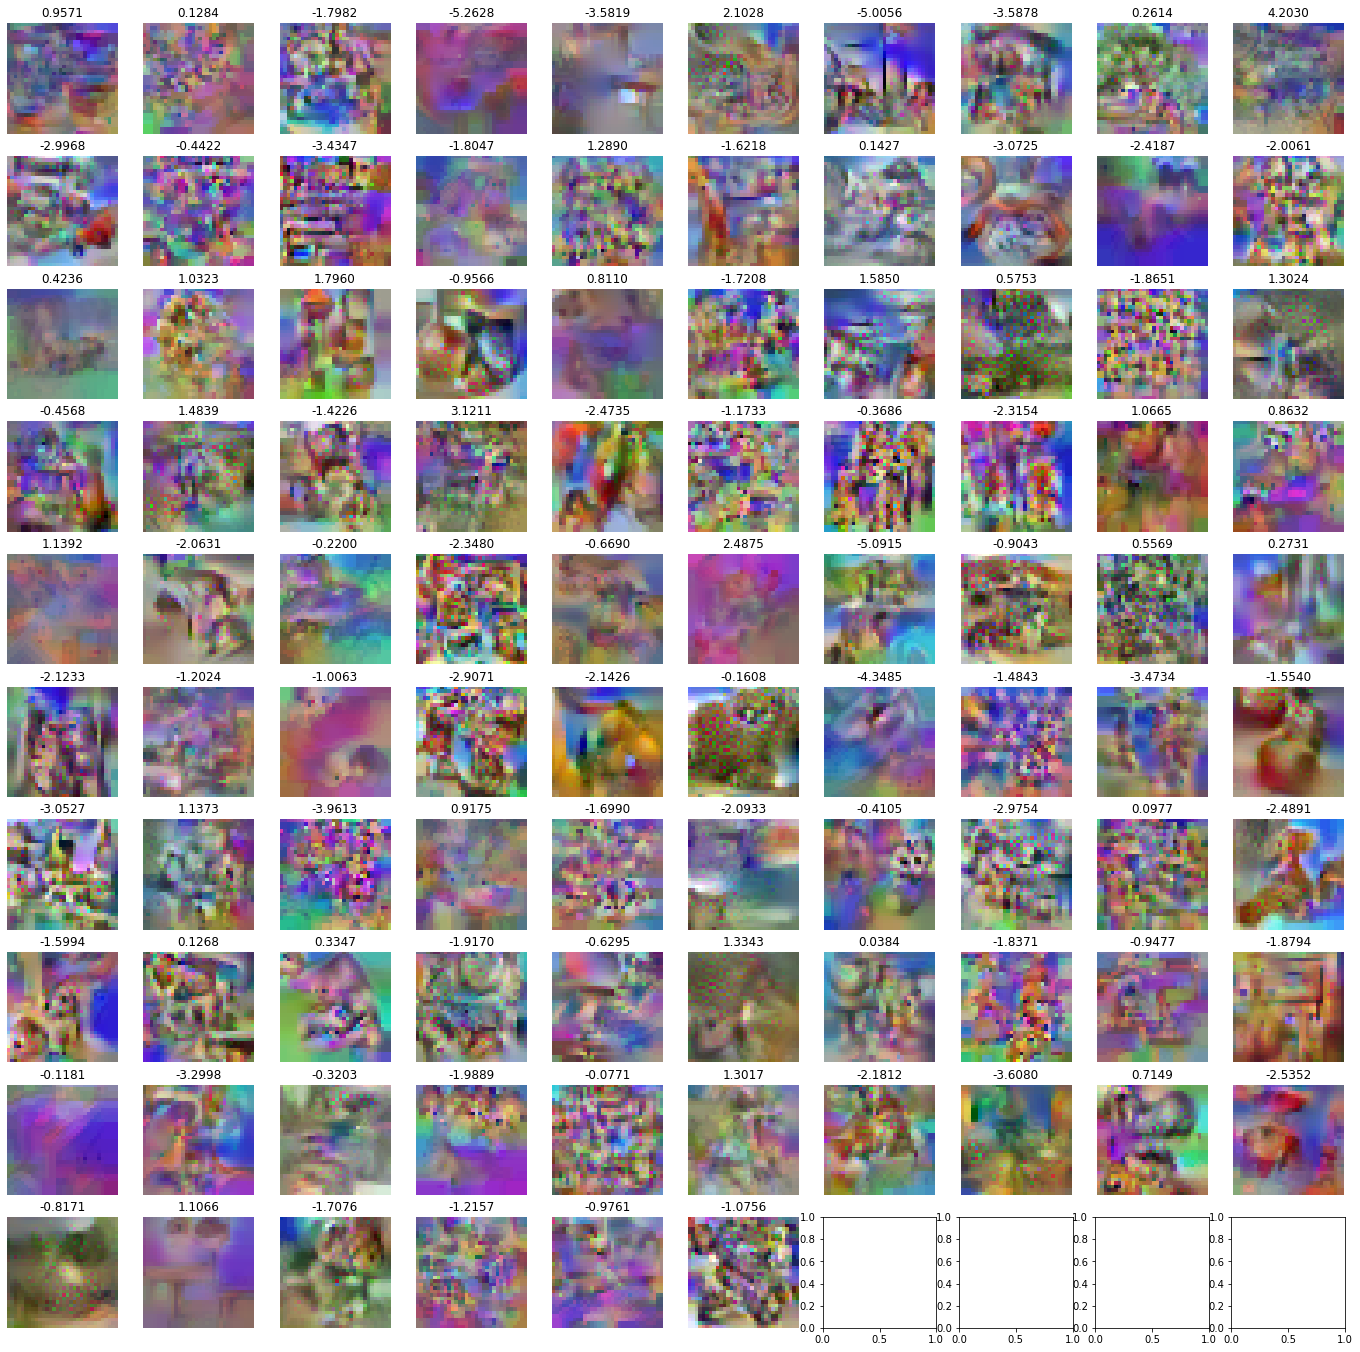

In [36]:
grid_plot_psrn(output, [validloader.dataset.classes[l] for l in labels], psnr);
